# ⤵️Import Libraries 

In [1]:
import os
import re
import numpy as np
import pandas as pd
import datetime as dt

import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go

import xlrd
import pickle as pkl

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.stats.mstats import winsorize
from scipy.stats.mstats import zscore
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import OneHotEncoder

In [2]:
col_pal = ['#8236CB', 
           '#EB2632']

# 📂Load Data

In [3]:
os.chdir('..')
curr_dir = (os.getcwd()).replace('\\', '/')
file_path = curr_dir + '/Dataset/Prcsd_Healthcare_dataset.xlsx'

In [4]:
drug_df = pd.read_excel(file_path)

In [5]:
drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 66 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   ptid                                                                3424 non-null   object
 1   persistency_flag                                                    3424 non-null   object
 2   region                                                              3424 non-null   object
 3   age_bucket                                                          3424 non-null   object
 4   ntm_specialist_flag                                                 3424 non-null   object
 5   ntm_speciality_bucket                                               3424 non-null   object
 6   gluco_record_prior_ntm                                              3424 non-null   object
 7   gluco_record_during_rx  

# 🔍Exploratory Data Analysis(EDA)

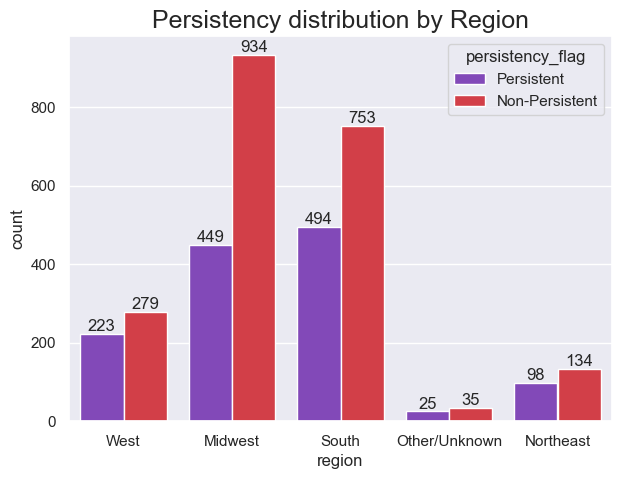

In [6]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='region', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax.set_title('Persistency distribution by Region', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

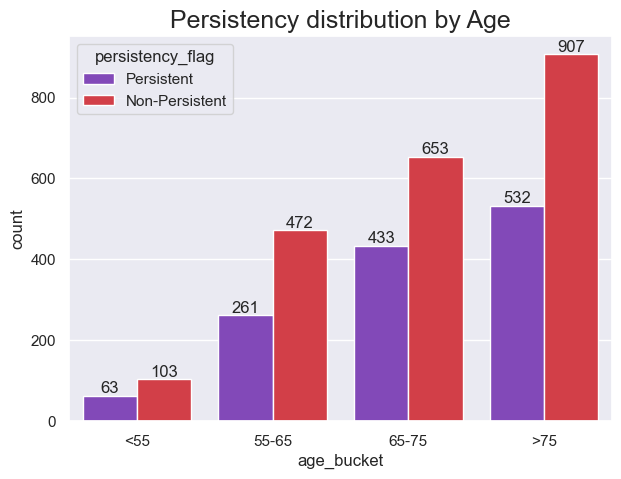

In [40]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='age_bucket', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal, 
                   order=['<55', '55-65', '65-75', '>75'])
ax.set_title('Persistency distribution by Age', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

In [66]:
def create_age_distribution_grid(region_list, 
                                 drug_df, 
                                 col_pal):
    num_regions = len(region_list)
    nrows = num_regions//2
    ncols = num_regions-2
    
    max_count = 0
    
    fig, axes = plt.subplots(nrows=nrows, 
                             ncols=ncols, 
                             figsize=(15, 10))

    for i, region in enumerate(region_list):
        row_idx = i // ncols
        col_idx = i % ncols
        
        ax = axes[row_idx, col_idx]
        sns.set(rc={'figure.figsize': (7, 5)})
        sns.countplot(x='age_bucket',
                      data=drug_df[drug_df['region'] == region],
                      hue='persistency_flag',
                      palette=col_pal,
                      ax=ax, 
                      order=['<55', '55-65', '65-75', '>75'])
        ax.set_title('Age distribution by {}'.format(region), 
                     fontsize=12, 
                     pad=15)
        for label in ax.containers:
            ax.bar_label(label)
            
        current_max = max(ax.patches, 
                          key=lambda x: x.get_height()).get_height()
        max_count = max(max_count, 
                        current_max)
    
    # Setting same y limits for all the plots in the grid
    for i in range(num_regions):
        row_idx = i // ncols
        col_idx = i % ncols
        ax = axes[row_idx, col_idx]
        ax.set_ylim(0, max_count + 1)
        
    # Removing empty subplots, if any
    for i in range(num_regions, nrows * ncols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

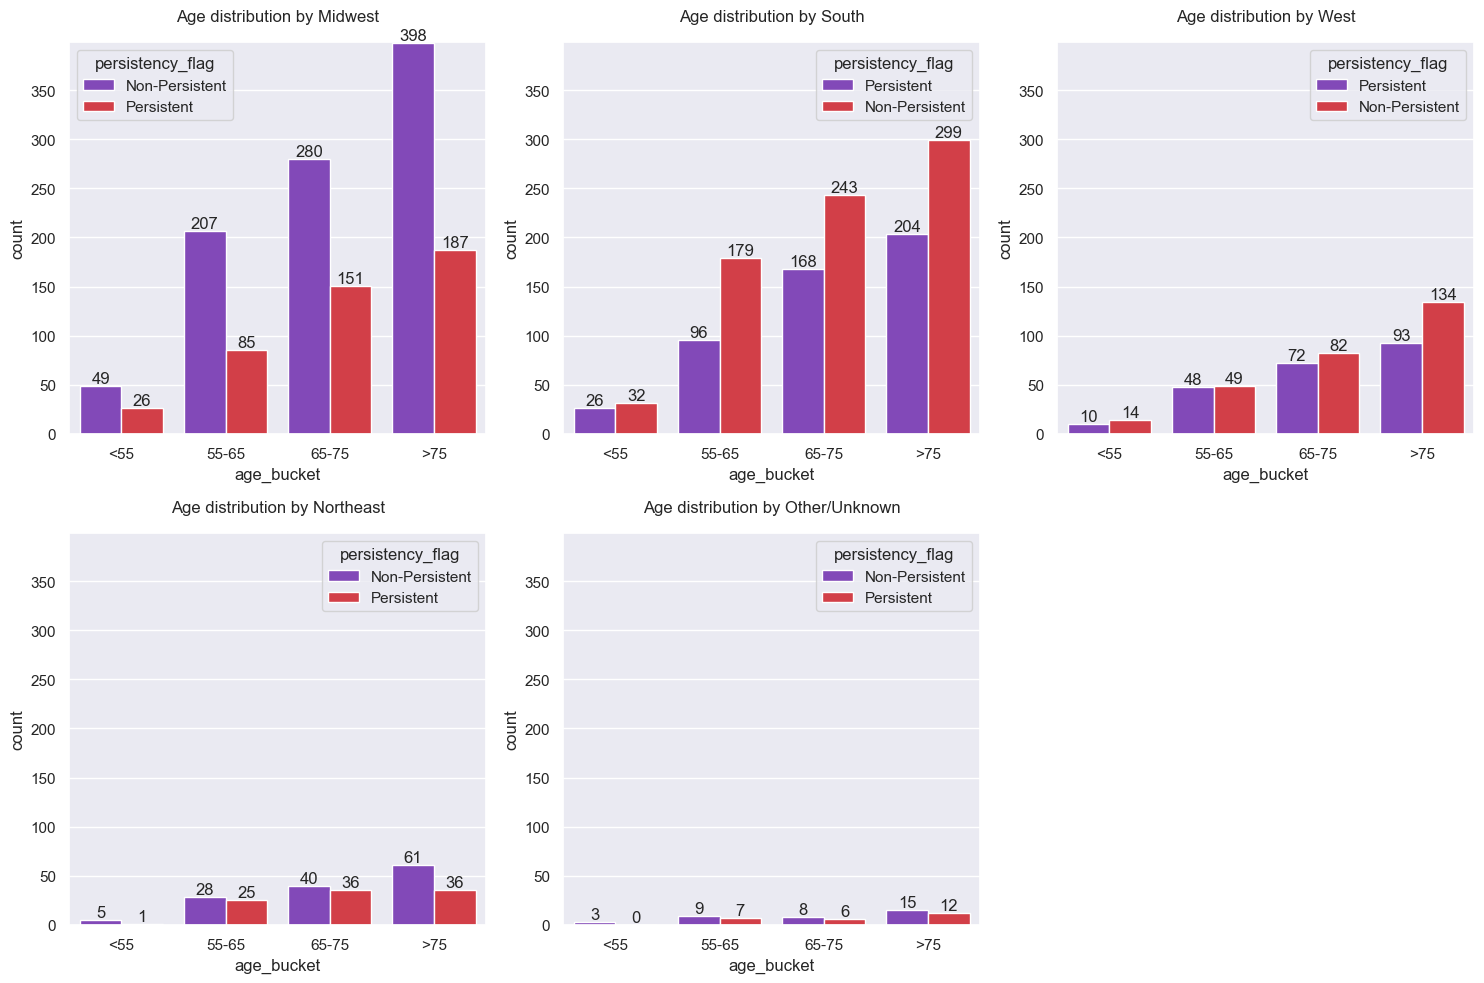

In [67]:
region_list = list(drug_df['region'].value_counts().index)
create_age_distribution_grid(region_list, drug_df, col_pal)

- Based on the distribution by region, we can conclude that majority recordings are from *Midwest* and *South* regions.
- Majority of the patients recorded are above 55 years of age.

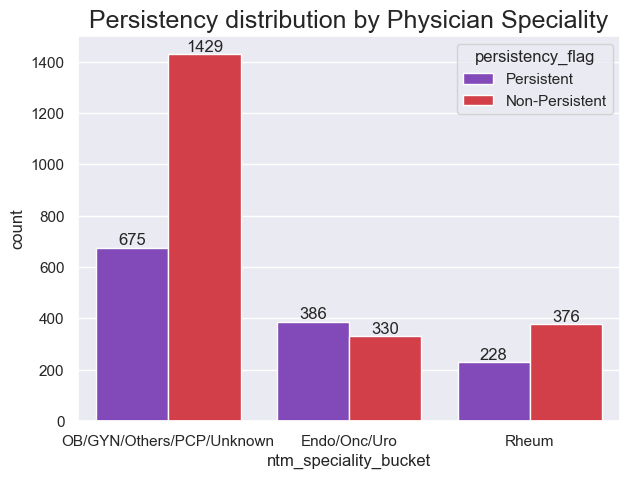

In [94]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='ntm_speciality_bucket', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Persistency distribution by Physician Speciality', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

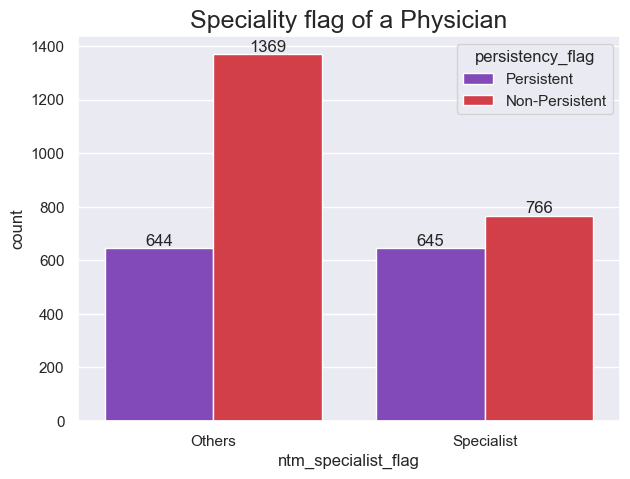

In [9]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='ntm_specialist_flag', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Speciality flag of a Physician', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

In [75]:
def create_physpc_distribution_grid(physician_cat, 
                                    drug_df, 
                                    col_pal):
    num_physicians = len(physician_cat)    
    max_count = 0
    
    fig, axes = plt.subplots(nrows=1, 
                             ncols=num_physicians, 
                             figsize=(15, 5))

    for i, physician in enumerate(physician_cat):
        ax = axes[i]
        sns.set(rc={'figure.figsize': (7, 5)})
        sns.countplot(x='ntm_specialist_flag',
                      data=drug_df[drug_df['ntm_speciality_bucket'] == physician],
                      hue='persistency_flag',
                      palette=col_pal,
                      ax=ax)
        ax.set_title('Specialist distribution by {}'.format(physician), 
                     fontsize=12, 
                     pad=15)
        for label in ax.containers:
            ax.bar_label(label)
            
        current_max = max(ax.patches, 
                          key=lambda x: x.get_height()).get_height()
        max_count = max(max_count, 
                        current_max)
    
    # Setting same y limits for all the plots in the grid
    for i in range(num_physicians):
        ax = axes[i]
        ax.set_ylim(0, max_count + 1)

    plt.tight_layout()
    plt.show()

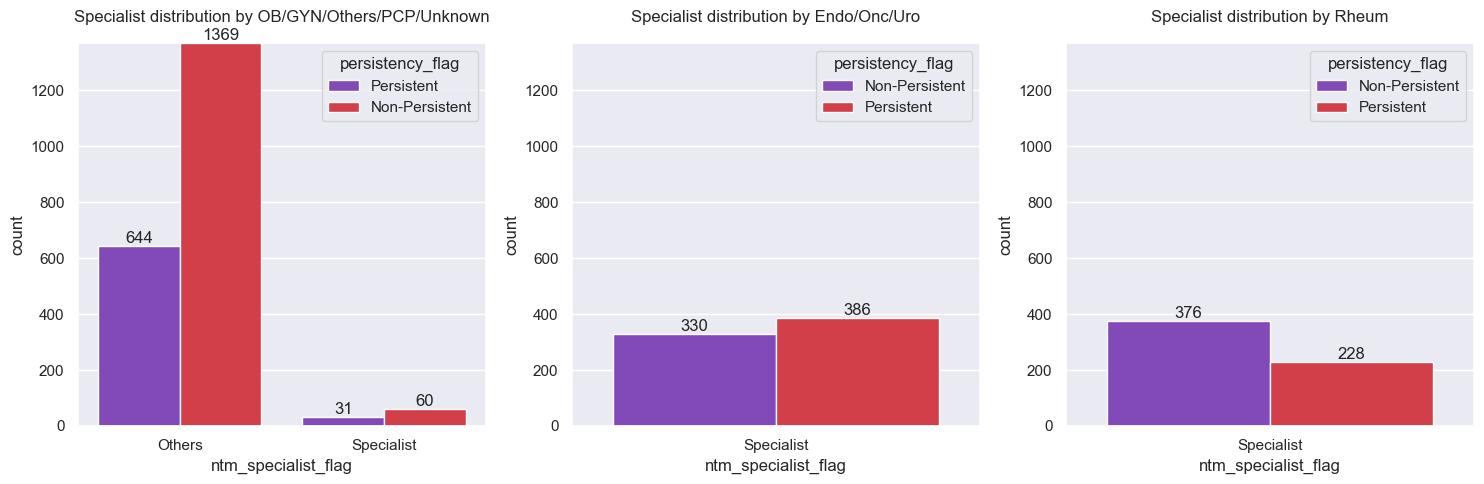

In [76]:
physician_cat = list(drug_df['ntm_speciality_bucket'].value_counts().index)
create_physpc_distribution_grid(physician_cat, drug_df, col_pal)

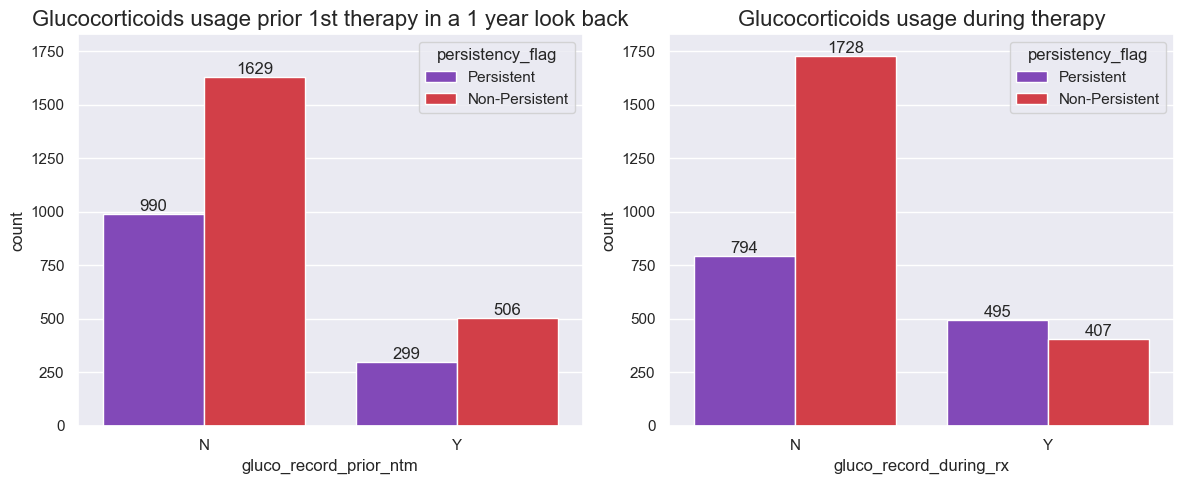

In [115]:
figure, ax = plt.subplots(1, 2,
                         figsize=(12,5))

max_count = max(
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['gluco_record_during_rx'] == 'N')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['gluco_record_during_rx'] == 'Y')])),
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['gluco_record_prior_ntm'] == 'N')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['gluco_record_prior_ntm'] == 'Y')]))
)

plt.subplot(1, 2, 1)
ax[0] = sns.countplot(x='gluco_record_prior_ntm', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax[0].set_title('Glucocorticoids usage prior 1st therapy in a 1 year look back', 
             fontsize=16)
for label in ax[0].containers:
    ax[0].bar_label(label)

plt.subplot(1, 2, 2)
ax[1] = sns.countplot(x='gluco_record_during_rx', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax[1].set_title('Glucocorticoids usage during therapy', 
             fontsize=16)
for label in ax[1].containers:
    ax[1].bar_label(label)

for i in range(2):
    ax[i].set_ylim(0, max_count + 100)

plt.tight_layout()
plt.show()

When we consider the case of usage *Glucocorticoids*, the **Persistent** patients are less compared to **Non-Persistent** patients prior to therapy but vice-versa during therapy. There is increase in the number of patients using *Glucocorticoids* during therapy.

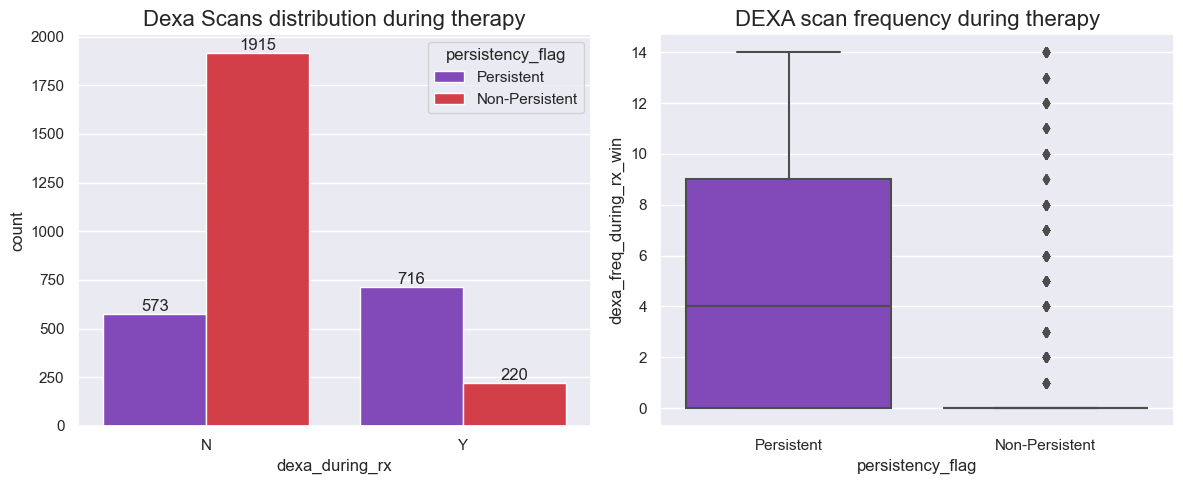

In [12]:
figure, ax = plt.subplots(1, 2,
                         figsize=(12,5))

plt.subplot(1, 2, 1)
ax[0] = sns.countplot(x='dexa_during_rx', 
                      data=drug_df, 
                      hue='persistency_flag', 
                      palette=col_pal)
ax[0].set_title('Dexa Scans distribution during therapy', 
             fontsize=16)
for label in ax[0].containers:
    ax[0].bar_label(label)

plt.subplot(1, 2, 2)
ax[1] = sns.boxplot(y='dexa_freq_during_rx_win', 
                    x='persistency_flag',
                    data=drug_df,
                    palette=col_pal)
ax[1].set_title('DEXA scan frequency during therapy', 
                fontsize=16)

plt.tight_layout()
plt.show()

*Dexa scan* tests are bone density tests to check the bone strenght.
- Based on the above graph, the *Dexa Scans* is part of the therapy and majority of patients who haven't gone though *Dexa Scans* are **Non-Persistent**.
- *Persistent* patients go though multiple scans during the theraphy.

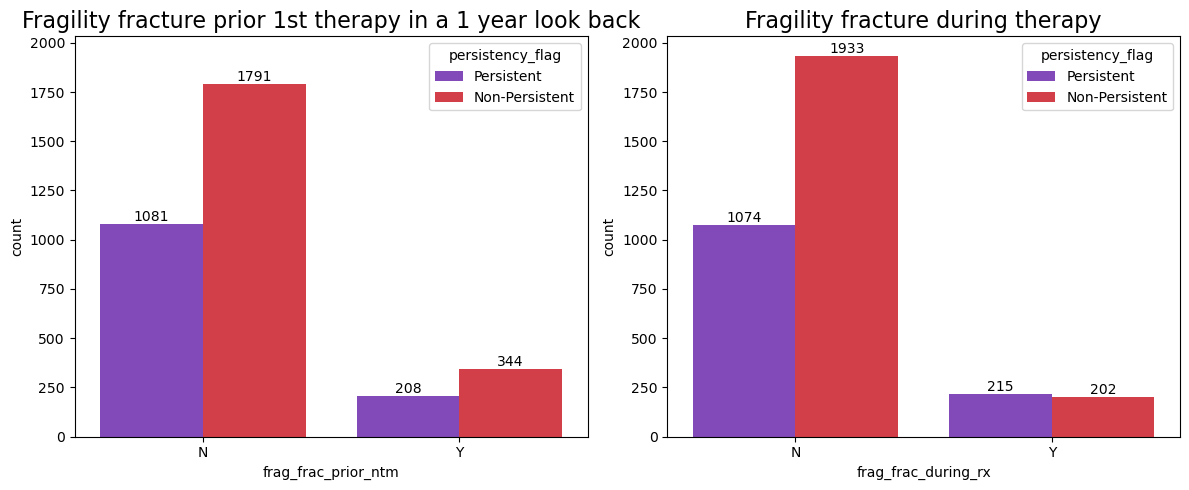

In [18]:
figure, ax = plt.subplots(1, 2,
                         figsize=(12,5))

max_count = max(
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['frag_frac_during_rx'] == 'N')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['frag_frac_during_rx'] == 'Y')])),
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['frag_frac_prior_ntm'] == 'N')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['frag_frac_prior_ntm'] == 'Y')]))
)

plt.subplot(1, 2, 1)
ax[0] = sns.countplot(x='frag_frac_prior_ntm',
                      data=drug_df, 
                      hue='persistency_flag', 
                      palette=col_pal)
ax[0].set_title('Fragility fracture prior 1st therapy in a 1 year look back', 
             fontsize=16)
for label in ax[0].containers:
    ax[0].bar_label(label)

plt.subplot(1, 2, 2)
ax[1] = sns.countplot(x='frag_frac_during_rx',
                      data=drug_df, 
                      hue='persistency_flag', 
                      palette=col_pal)
ax[1].set_title('Fragility fracture during therapy', 
             fontsize=16)
for label in ax[1].containers:
    ax[1].bar_label(label)

for i in range(2):
    ax[i].set_ylim(0, max_count + 100)

plt.tight_layout()
plt.show()

*Fragility Fracture* describes the fractures resulting from fall from standing heights or less. 

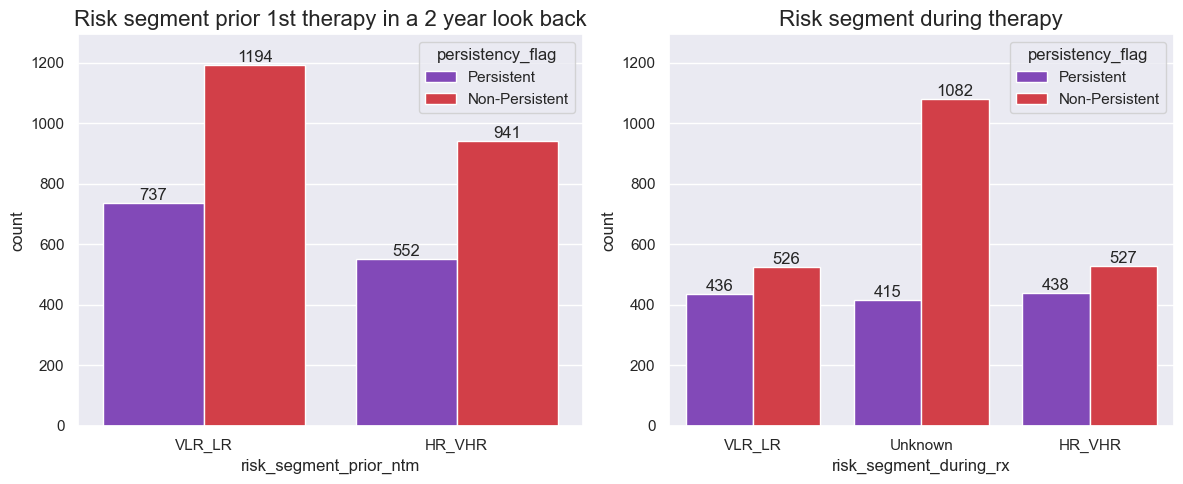

In [23]:
 figure, ax = plt.subplots(1, 2,
                         figsize=(12,5))

max_count = max(
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['risk_segment_during_rx'] == 'VLR_LR')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['risk_segment_during_rx'] == 'HR_VHR')])),
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['risk_segment_prior_ntm'] == 'VLR_LR')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['risk_segment_prior_ntm'] == 'HR_VHR')]))
)

plt.subplot(1, 2, 1)
ax[0] = sns.countplot(x='risk_segment_prior_ntm',
                      data=drug_df, 
                      hue='persistency_flag', 
                      palette=col_pal)
ax[0].set_title('Risk segment prior 1st therapy in a 2 year look back', 
             fontsize=16)
for label in ax[0].containers:
    ax[0].bar_label(label)

plt.subplot(1, 2, 2)
ax[1] = sns.countplot(x='risk_segment_during_rx',
                      data=drug_df, 
                      hue='persistency_flag', 
                      palette=col_pal)
ax[1].set_title('Risk segment during therapy', 
             fontsize=16)
for label in ax[1].containers:
    ax[1].bar_label(label)

for i in range(2):
    ax[i].set_ylim(0, max_count + 100)

plt.tight_layout()
plt.show()

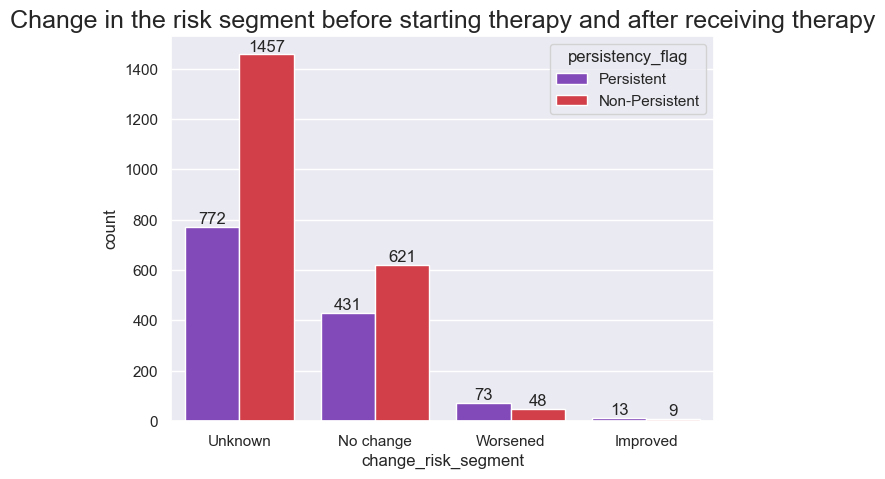

In [24]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='change_risk_segment', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Change in the risk segment before starting therapy and after receiving therapy', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

The *Risk segment during therapy* feature also contains *Unknown* categgory as a value which means there is a possibility of a third category other than **VLR_LR** or **HR_VHR**. 
Assuming that risk segment and change in risk segment for majority of patients is not known during therapy, we can drop these features as they don't provide any useful information.

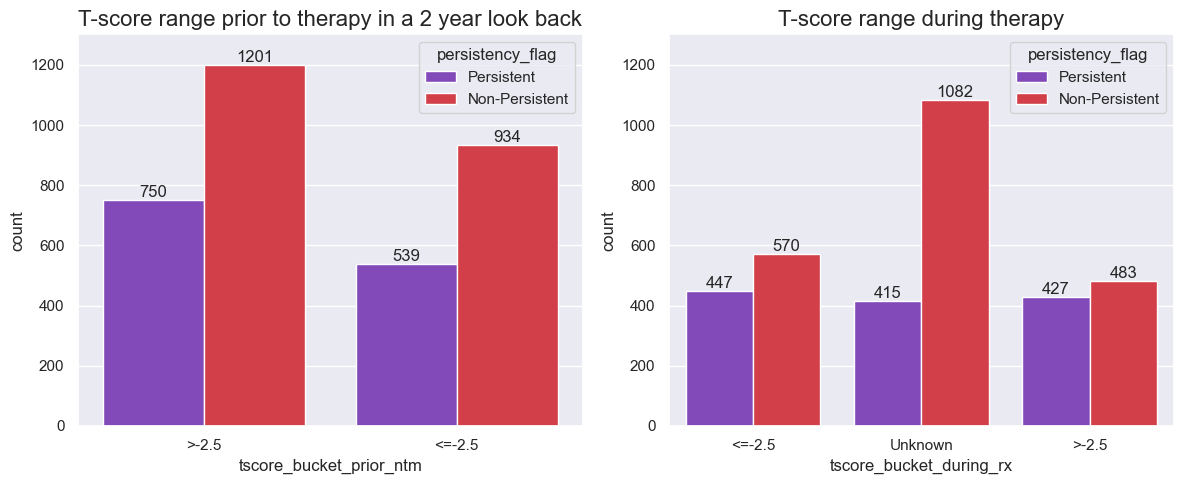

In [32]:
figure, ax = plt.subplots(1, 2,
                         figsize=(12,5))

max_count = max(
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['tscore_bucket_during_rx'] == '<=-2.5')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['tscore_bucket_during_rx'] == '>-2.5')])),
    max(len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['tscore_bucket_prior_ntm'] == '<=-2.5')]), \
        len(drug_df[(drug_df['persistency_flag'] == 'Non-Persistent') & (drug_df['tscore_bucket_prior_ntm'] == '>-2.5')]))
)

plt.subplot(1, 2, 1)
ax[0] = sns.countplot(x='tscore_bucket_prior_ntm',
                      data=drug_df, 
                      hue='persistency_flag', 
                      palette=col_pal)
ax[0].set_title('T-score range prior to therapy in a 2 year look back', 
             fontsize=16)
for label in ax[0].containers:
    ax[0].bar_label(label)

plt.subplot(1, 2, 2)
ax[1] = sns.countplot(x='tscore_bucket_during_rx',
                      data=drug_df, 
                      hue='persistency_flag', 
                      palette=col_pal)
ax[1].set_title('T-score range during therapy', 
             fontsize=16)
for label in ax[1].containers:
    ax[1].bar_label(label)

for i in range(2):
    ax[i].set_ylim(0, max_count + 100)

plt.tight_layout()
plt.show()

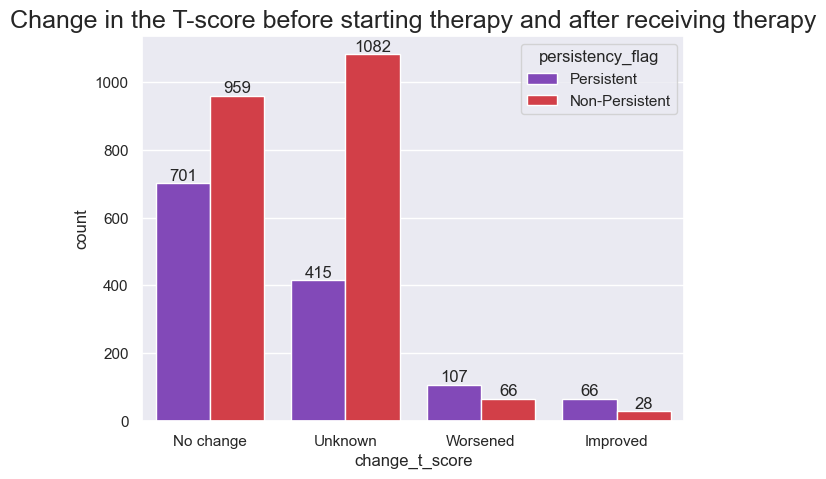

In [46]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='change_t_score', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Change in the T-score before starting therapy and after receiving therapy', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

In [10]:
columns = list(drug_df.columns)

print('Below is the list of features containing count of \'Unknown\' category value:')
for col in columns:
    if drug_df[col].dtype != np.int64:
        unknwn_val = drug_df[col].str.contains('Unknown').sum()
        if unknwn_val != 0:
            print('{}: {}'.format(col, unknwn_val))

Below is the list of features containing count of 'Unknown' category value:
region: 60
ntm_speciality_bucket: 2104
risk_segment_during_rx: 1497
tscore_bucket_during_rx: 1497
change_t_score: 1497
change_risk_segment: 2229


In [29]:
drug_df['adherent_flag'].value_counts()

adherent_flag
Adherent        3251
Non-Adherent     173
Name: count, dtype: int64

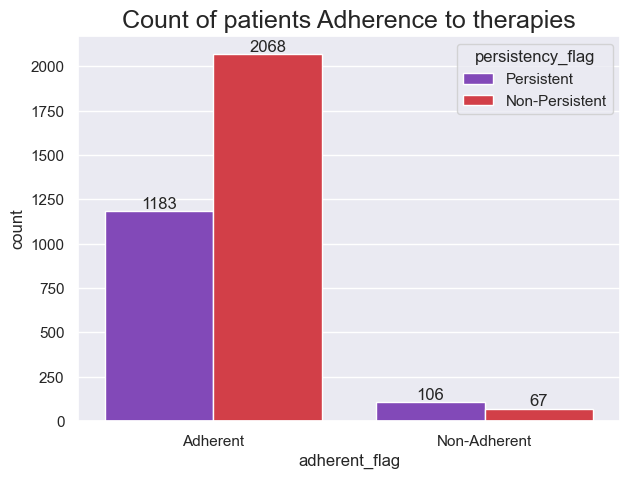

In [30]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='adherent_flag', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Count of patients Adherence to therapies', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

- Above plot contradicts the persistency of the patient to NTM Rx. We can see that majority of the *Non-Persistent* patients were adherent to the therapies.
- The *Non-Persistency* can be due to the some other factors other than *Adherency*.

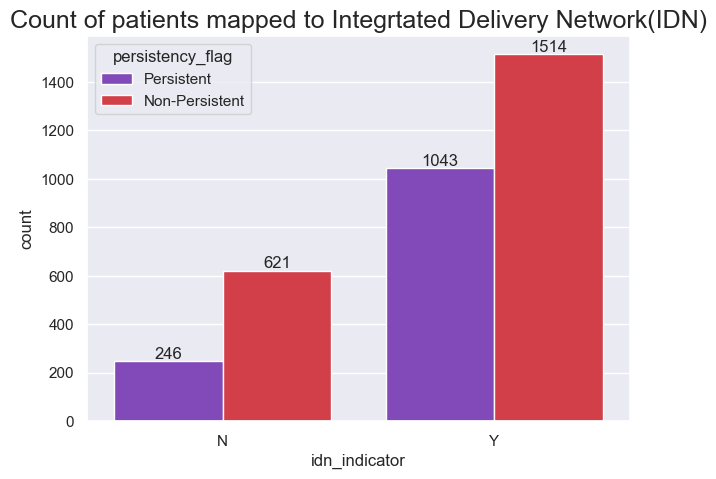

In [32]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='idn_indicator', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Count of patients mapped to Integrtated Delivery Network(IDN)', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

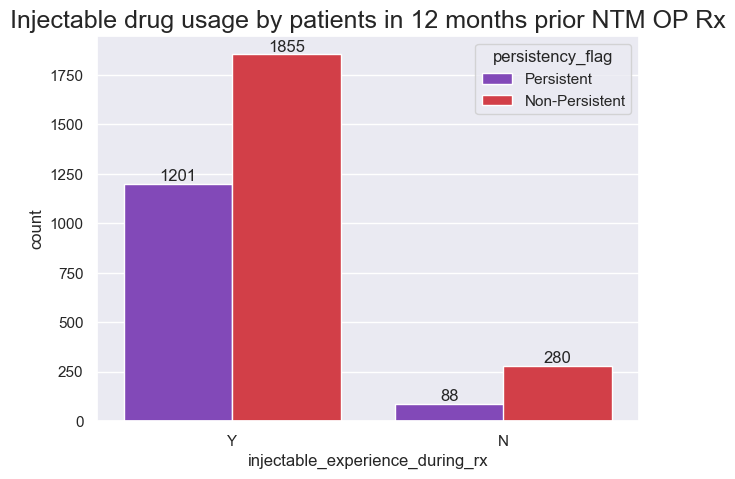

In [9]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='injectable_experience_during_rx', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Injectable drug usage by patients in 12 months prior NTM OP Rx', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

In [53]:
risk_factors = []
for col in columns:
    if col.startswith('risk_') & (col != 'risk_segment_prior_ntm') & (col != 'risk_segment_during_rx'):
        risk_factors.append(col)
        
risk_factors

['risk_type_1_insulin_dependent_diabetes',
 'risk_osteogenesis_imperfecta',
 'risk_rheumatoid_arthritis',
 'risk_untreated_chronic_hyperthyroidism',
 'risk_untreated_chronic_hypogonadism',
 'risk_untreated_early_menopause',
 'risk_patient_parent_fractured_their_hip',
 'risk_smoking_tobacco',
 'risk_chronic_malnutrition_or_malabsorption',
 'risk_chronic_liver_disease',
 'risk_family_history_of_osteoporosis',
 'risk_low_calcium_intake',
 'risk_vitamin_d_insufficiency',
 'risk_poor_health_frailty',
 'risk_excessive_thinness',
 'risk_hysterectomy_oophorectomy',
 'risk_estrogen_deficiency',
 'risk_immobilization',
 'risk_recurring_falls']

In [118]:
risk_factor_df = pd.DataFrame(columns=['risk_factor', 'patient_count', \
                                       'persistent_patient_count', 'non-persistent_patient_count'])

for idx, col in enumerate(risk_factors):
    if drug_df[drug_df['persistency_flag'] == 'Persistent'][col].str.contains('Y').any() :
        pers_count = drug_df[drug_df['persistency_flag'] == 'Persistent'][col].value_counts()[1]
    else:
        pers_count = 0
        
    if drug_df[drug_df['persistency_flag'] == 'Non-Persistent'][col].str.contains('Y').any() :
        npers_count = drug_df[drug_df['persistency_flag'] == 'Non-Persistent'][col].value_counts()[1]
    else:
        npers_count = 0
        
    risk_factor_df.loc[idx] = [col.replace('risk_', '')] + [drug_df[col].value_counts()[1]] + [pers_count] + [npers_count]
    
risk_factor_df.sort_values(by='patient_count', 
                           ascending=False, 
                           inplace=True, 
                           ignore_index=True)

In [119]:
risk_factor_df

,risk_factor,patient_count,persistent_patient_count,non-persistent_patient_count
0,vitamin_d_insufficiency,1636,607,954
1,smoking_tobacco,644,306,338
2,chronic_malnutrition_or_malabsorption,470,205,265
3,family_history_of_osteoporosis,358,133,225
4,patient_parent_fractured_their_hip,256,100,156
5,poor_health_frailty,192,55,137
6,type_1_insulin_dependent_diabetes,139,46,93
7,rheumatoid_arthritis,130,66,64
8,untreated_chronic_hypogonadism,127,69,58
9,recurring_falls,69,21,48


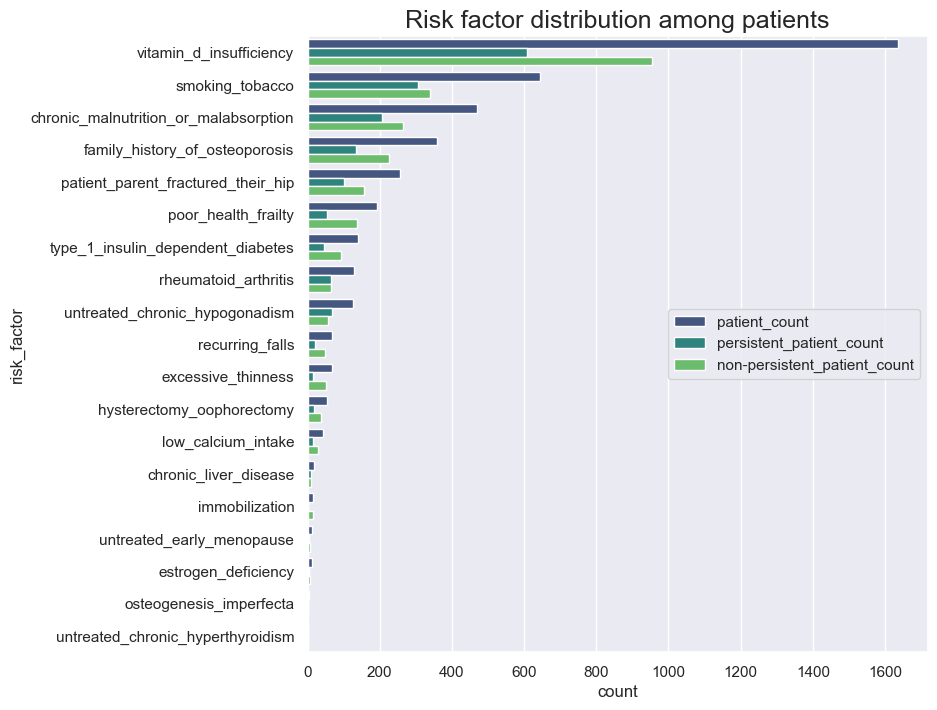

In [137]:
risk_factor_df_meltd = risk_factor_df.melt(id_vars='risk_factor', 
                                           var_name='Count Type', 
                                           value_name='count')

sns.set(rc = {'figure.figsize':(8,8)})
ax = sns.barplot(y='risk_factor', 
                 x='count',
                 data=risk_factor_df_meltd, 
                 hue='Count Type',
                 palette='viridis')

ax.set_title('Risk factor distribution among patients', 
             fontsize=18)
ax.legend(loc='center right')

In [91]:
comorbidity_factors = []
for col in columns:
    if col.startswith('comorb_'):
        comorbidity_factors.append(col)
        
comorbidity_factors

['comorb_encounter_for_screening_for_malignant_neoplasms',
 'comorb_encounter_for_immunization',
 'comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx',
 'comorb_vitamin_d_deficiency',
 'comorb_other_joint_disorder_not_elsewhere_classified',
 'comorb_encntr_for_oth_sp_exam_w_o_complaint_suspected_or_reprtd_dx',
 'comorb_long_term_current_drug_therapy',
 'comorb_dorsalgia',
 'comorb_personal_history_of_other_diseases_and_conditions',
 'comorb_other_disorders_of_bone_density_and_structure',
 'comorb_disorders_of_lipoprotein_metabolism_and_other_lipidemias',
 'comorb_osteoporosis_without_current_pathological_fracture',
 'comorb_personal_history_of_malignant_neoplasm',
 'comorb_gastro_esophageal_reflux_disease']

In [130]:
comorb_factor_df = pd.DataFrame(columns=['comorbidity_factor', 'patient_count', \
                                       'persistent_patient_count', 'non-persistent_patient_count'])

for idx, col in enumerate(comorbidity_factors):
    if drug_df[drug_df['persistency_flag'] == 'Persistent'][col].str.contains('Y').any() :
        pers_count = drug_df[drug_df['persistency_flag'] == 'Persistent'][col].value_counts()[1]
    else:
        pers_count = 0
        
    if drug_df[drug_df['persistency_flag'] == 'Non-Persistent'][col].str.contains('Y').any() :
        npers_count = drug_df[drug_df['persistency_flag'] == 'Non-Persistent'][col].value_counts()[1]
    else:
        npers_count = 0
        
    comorb_factor_df.loc[idx] = [col.replace('comorb_', '')] + [drug_df[col].value_counts()[1]] + [pers_count] + [npers_count]
    
comorb_factor_df.sort_values(by='patient_count', 
                             ascending=False, 
                             inplace=True, 
                             ignore_index=True)

In [131]:
comorb_factor_df

,comorbidity_factor,patient_count,persistent_patient_count,non-persistent_patient_count
0,disorders_of_lipoprotein_metabolism_and_other_...,1659,489,965
1,encounter_for_screening_for_malignant_neoplasms,1533,446,690
2,encounter_for_immunization,1513,460,684
3,"encntr_for_general_exam_w_o_complaint,_susp_or...",1352,545,608
4,vitamin_d_deficiency,1093,545,548
5,other_joint_disorder_not_elsewhere_classified,999,552,447
6,osteoporosis_without_current_pathological_frac...,917,448,469
7,long_term_current_drug_therapy,817,557,260
8,encntr_for_oth_sp_exam_w_o_complaint_suspected...,791,447,344
9,dorsalgia,779,443,336


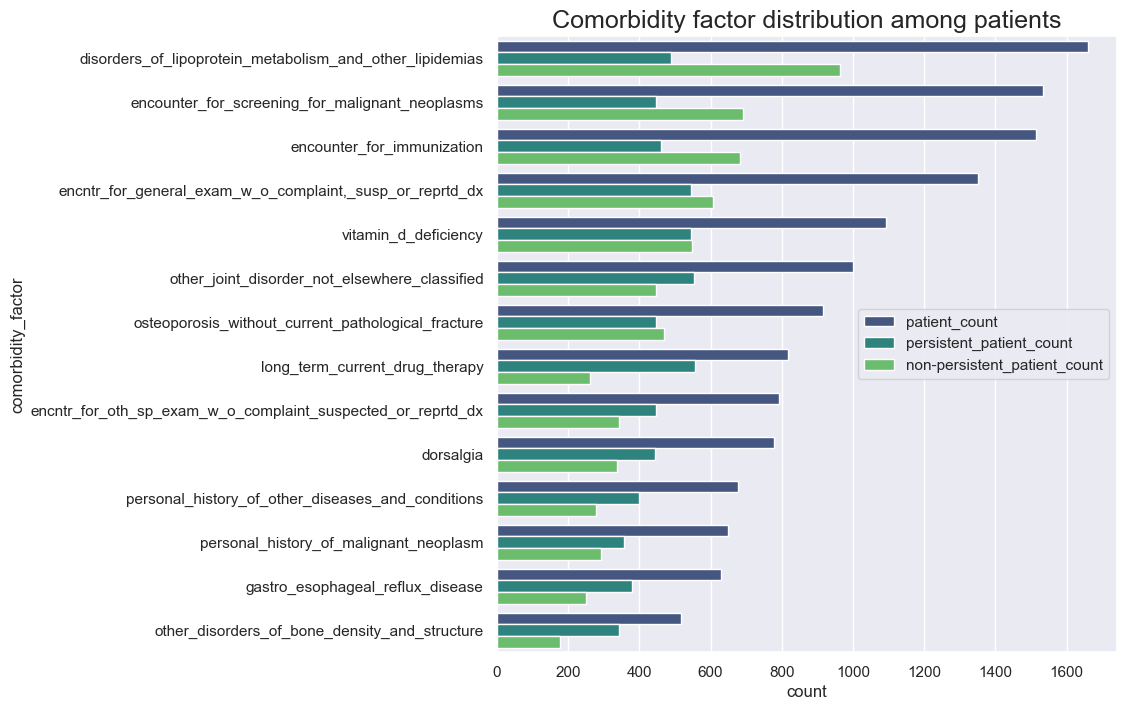

In [136]:
comorb_factor_df_meltd = comorb_factor_df.melt(id_vars='comorbidity_factor', 
                                               var_name='Count Type', 
                                               value_name='count')

sns.set(rc = {'figure.figsize':(8,8)})
ax = sns.barplot(y='comorbidity_factor', 
                 x='count',
                 data=comorb_factor_df_meltd, 
                 hue='Count Type',
                 palette='viridis')

ax.set_title('Comorbidity factor distribution among patients', 
             fontsize=18)
ax.legend(loc='center right')

In [96]:
concomitant_drugs = []
for col in columns:
    if col.startswith('concom_'):
        concomitant_drugs.append(col)
        
concomitant_drugs

['concom_cholesterol_and_triglyceride_regulating_preparations',
 'concom_narcotics',
 'concom_systemic_corticosteroids_plain',
 'concom_anti_depressants_and_mood_stabilisers',
 'concom_fluoroquinolones',
 'concom_cephalosporins',
 'concom_macrolides_and_similar_types',
 'concom_broad_spectrum_penicillins',
 'concom_anaesthetics_general',
 'concom_viral_vaccines']

In [133]:
cocom_drug_df = pd.DataFrame(columns=['concomitant_drug', 'patient_count', \
                                       'persistent_patient_count', 'non-persistent_patient_count'])

for idx, col in enumerate(concomitant_drugs):
    if drug_df[drug_df['persistency_flag'] == 'Persistent'][col].str.contains('Y').any() :
        pers_count = drug_df[drug_df['persistency_flag'] == 'Persistent'][col].value_counts()[1]
    else:
        pers_count = 0
        
    if drug_df[drug_df['persistency_flag'] == 'Non-Persistent'][col].str.contains('Y').any() :
        npers_count = drug_df[drug_df['persistency_flag'] == 'Non-Persistent'][col].value_counts()[1]
    else:
        npers_count = 0
        
    cocom_drug_df.loc[idx] = [col.replace('concom_', '')] + [drug_df[col].value_counts()[1]] + [pers_count] + [npers_count]
    
cocom_drug_df.sort_values(by='patient_count', 
                          ascending=False, 
                          inplace=True, 
                          ignore_index=True)

In [134]:
cocom_drug_df

,concomitant_drug,patient_count,persistent_patient_count,non-persistent_patient_count
0,narcotics,1233,617,616
1,cholesterol_and_triglyceride_regulating_prepar...,1182,544,638
2,systemic_corticosteroids_plain,973,548,425
3,anti_depressants_and_mood_stabilisers,959,443,516
4,fluoroquinolones,637,360,277
5,cephalosporins,603,367,236
6,macrolides_and_similar_types,571,352,219
7,anaesthetics_general,497,317,180
8,broad_spectrum_penicillins,439,275,164
9,viral_vaccines,353,245,108


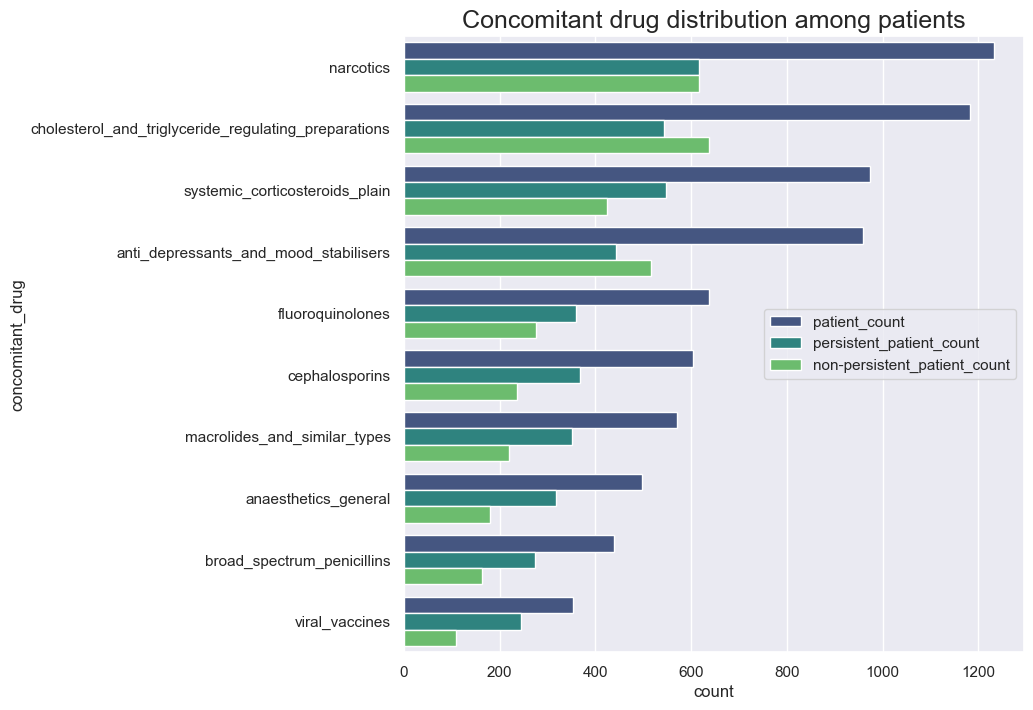

In [135]:
cocom_drug_df_meltd = cocom_drug_df.melt(id_vars='concomitant_drug', 
                                         var_name='Count Type', 
                                         value_name='count')

sns.set(rc = {'figure.figsize':(8,8)})
ax = sns.barplot(y='concomitant_drug', 
                 x='count',
                 data=cocom_drug_df_meltd, 
                 hue='Count Type',
                 palette='viridis')

ax.set_title('Concomitant drug distribution among patients', 
             fontsize=18)
ax.legend(loc='center right')